In [144]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [145]:
SYMBOL = "QQQ"
START_DATE = "2022-01-01"
END_DATE = "2026-01-15"
df = yf.download(SYMBOL, start= START_DATE, end =END_DATE, interval = "1d")
df = df.reset_index()
print(df)

C:\Users\billy\AppData\Local\Temp\ipykernel_33564\930250307.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(SYMBOL, start= START_DATE, end =END_DATE, interval = "1d")
[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open    Volume
Ticker                    QQQ         QQQ         QQQ         QQQ       QQQ
0      2022-01-03  391.679413  391.932949  386.998930  389.114887  40575900
1      2022-01-04  386.599152  392.264499  383.498331  392.225486  58027200
2      2022-01-05  374.722443  386.033646  374.468906  384.912254  75739800
3      2022-01-06  374.459137  377.706247  370.666001  372.898996  70814300
4      2022-01-07  370.402679  376.155812  368.628014  374.468873  72652300
...           ...         ...         ...         ...         ...       ...
1007   2026-01-08  620.469971  623.419983  617.799988  623.030029  50435900
1008   2026-01-09  626.650024  627.890015  619.059998  621.409973  49688700
1009   2026-01-12  627.169983  628.849976  622.260010  622.309998  37388700
1010   2026-01-13  626.239990  629.469971  623.700012  627.270020  44481400
1011   2026-01-14  619.549988  623.450012  614.559998  622.239990  72598700

[1012 rows 

In [146]:
df["return"] = df["Close"].pct_change()
df["volatility"] = df["return"].rolling(5).std() 
df["ma_5"] = df["Close"].rolling(5).mean()
df["ma_10"] = df["Close"].rolling(10).mean()
df["ma_20"] = df["Close"].rolling(20).mean()
#macd
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df.dropna(inplace=True)
#rsi
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

df["target"] = df["Close"].pct_change().shift(-1)
df = df.dropna()

features = ["Close", "Volume","volatility", "ma_5", "ma_10", "ma_20",'MACD', 'MACD_Signal','RSI']


In [147]:
X = df[features] #today information(question)
y = df["target"] #tmr return

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  #<-avoid look ahead bias
)
model = RandomForestRegressor(  #use Random Forest Regressor model to predict return
    n_estimators=1000,    #1000 trees   
    max_depth=4,          #max 4 layers
    min_samples_leaf=100,   #min 100 leaves to anti-overfitting
    max_features='log2',    
    random_state=42,
    n_jobs=-1              #speed up
)
model.fit(X_train, Y_train)
preds = model.predict(X_test)
mae = mean_absolute_error(Y_test, preds)
print(f"Mean Absolute Error: ${mae:.2f}")

#validing rwt
baseline_preds = np.zeros_like(Y_test.values)        #tmr return = 0(in random walk theory, best prediction = 0 return)
baseline_mae = mean_absolute_error(Y_test, baseline_preds) #compare

print("Model MAE:", mae)
print("Baseline MAE (predict 0):", baseline_mae)



Mean Absolute Error: $0.01
Model MAE: 0.008605202306541658
Baseline MAE (predict 0): 0.008627833328277644


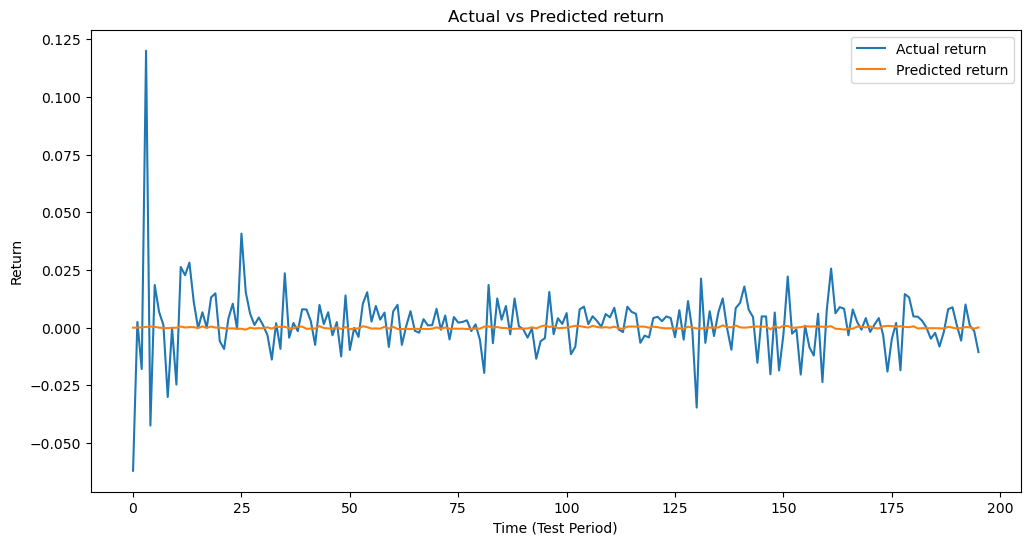

In [148]:
plt.figure(figsize=(12, 6))

plt.plot(Y_test.values, label="Actual return")
plt.plot(preds, label="Predicted return")

plt.title("Actual vs Predicted return")
plt.xlabel("Time (Test Period)")
plt.ylabel("Return")
plt.legend()

plt.show()